In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### 1. Collect Data

In [2]:
# Database connection
server = 'DESKTOP-FK1AJ2V'
database = 'la_liga_transfers'
driver = 'ODBC Driver 17 for SQL Server'
engine = create_engine(f'mssql+pyodbc://@{server}/{database}?driver={driver}')

# Query data from database
df_transfers = pd.read_sql('SELECT * FROM dbo.transfers_list', con=engine)
df_stats = pd.read_sql('SELECT * FROM dbo.player_stats', con=engine)
df_spanish_teams = pd.read_sql('SELECT * FROM dbo.spanish_teams', con=engine)


### 2. Data wrangling / Data cleaning

#### 2.3 Merge data-sets
- {merged_df} - List of players transferred to La liga clubs in the seasons from 2015/16 to 2022/23 and  their statistics in the first season after transfer

In [3]:
merged_df = df_transfers.merge(df_stats, how='inner', 
                               left_on=['player_id', 'player_name', 'transfers_teams_in_name', 'season_of_transfer'],
                               right_on=['player_id', 'player_name', 'statistics_team_name', 'statistics_league_season'])

In [4]:
merged_df.info()
merged_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1270 entries, 0 to 1269
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   player_id                         1270 non-null   int64         
 1   player_name                       1270 non-null   object        
 2   transfers_date                    1270 non-null   datetime64[ns]
 3   transfer_fee                      708 non-null    float64       
 4   transfers_teams_in_id             1270 non-null   int64         
 5   transfers_teams_in_name           1270 non-null   object        
 6   transfers_teams_out_id            1269 non-null   float64       
 7   transfers_teams_out_name          1269 non-null   object        
 8   season_of_transfer                1270 non-null   int64         
 9   transfers_window                  1270 non-null   object        
 10  player_firstname                  1270 non-null 

,player_id,player_name,transfers_date,transfer_fee,transfers_teams_in_id,transfers_teams_in_name,transfers_teams_out_id,transfers_teams_out_name,season_of_transfer,transfers_window,...,statistics_fouls_committed,statistics_cards_yellow,statistics_cards_yellowred,statistics_cards_red,statistics_penalty_won,statistics_penalty_commited,statistics_penalty_scored,statistics_penalty_missed,statistics_penalty_saved,performance_metric
0,642,S. Agüero,2021-07-01,0.0,529,Barcelona,50.0,Manchester City,2021,Summer,...,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.208752
1,36848,Aitor Cantalapiedra,2016-07-01,NaN,533,Villarreal,529.0,Barcelona,2016,Summer,...,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.000000
2,619,Eric García,2021-07-01,0.0,529,Barcelona,50.0,Manchester City,2021,Summer,...,34.0,5.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.259189


### 3. Exploratory Data Analysis

#### 3.1 Basic statistics of dataset

In [5]:
# Basic players statistics
selected_columns = ['transfer_fee', 'player_age', 'statistics_games_appearences', 'statistics_games_minutes', 'statistics_games_rating', 'statistics_goals_total', 'statistics_goals_assists']
merged_df[selected_columns].describe().round(2)

,transfer_fee,player_age,statistics_games_appearences,statistics_games_minutes,statistics_games_rating,statistics_goals_total,statistics_goals_assists
count,708.00,1270.00,1268.00,1268.00,1042.00,1268.00,484.00
mean,6.76,30.13,15.18,990.00,6.73,1.35,2.27
std,14.25,4.18,12.13,930.82,0.24,2.72,1.60
min,0.00,19.00,0.00,0.00,4.90,0.00,1.00
25%,0.00,27.00,2.00,90.00,6.60,0.00,1.00
50%,1.50,30.00,15.00,784.50,6.74,0.00,2.00
75%,7.00,33.00,26.00,1698.50,6.89,1.25,3.00
max,126.00,42.00,38.00,3420.00,7.50,23.00,12.00


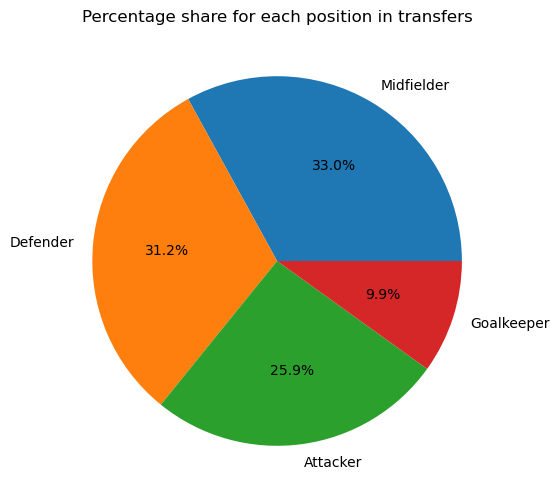

In [6]:
# Percentage share for each position in transfers
position_share = merged_df['statistics_games_position'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6)) 
plt.pie(position_share, labels=position_share.index, autopct='%1.1f%%')

plt.title('Percentage share for each position in transfers')

# Display the chart
plt.show()

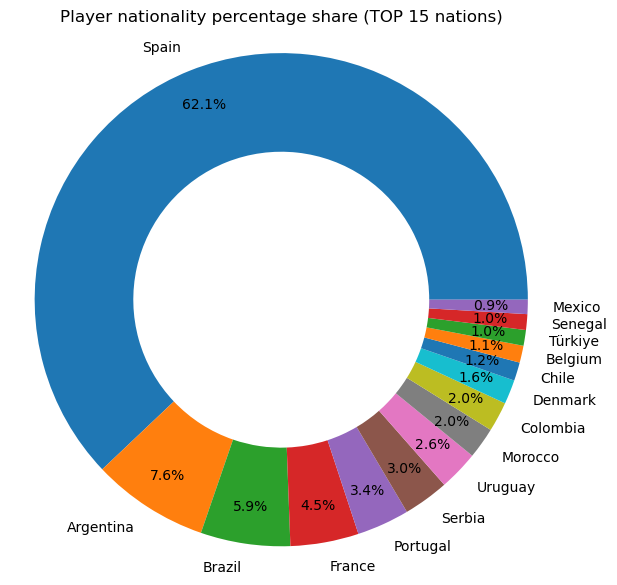

In [7]:
# Percentage share for players nationality in transfers
nationality_share = merged_df['player_nationality'].value_counts(normalize=True) * 100
nationality_share_top = nationality_share.round(2).head(15)

plt.figure(figsize=(7, 7)) 
plt.pie(nationality_share_top, labels=nationality_share_top.index, autopct='%1.1f%%', wedgeprops=dict(width=0.4), pctdistance=0.85)
plt.title('Player nationality percentage share (TOP 15 nations)')
plt.axis('equal')  # Equal aspect ratio ensures the donut shape
plt.show()

#### 3.2 Transfer fee statistics.

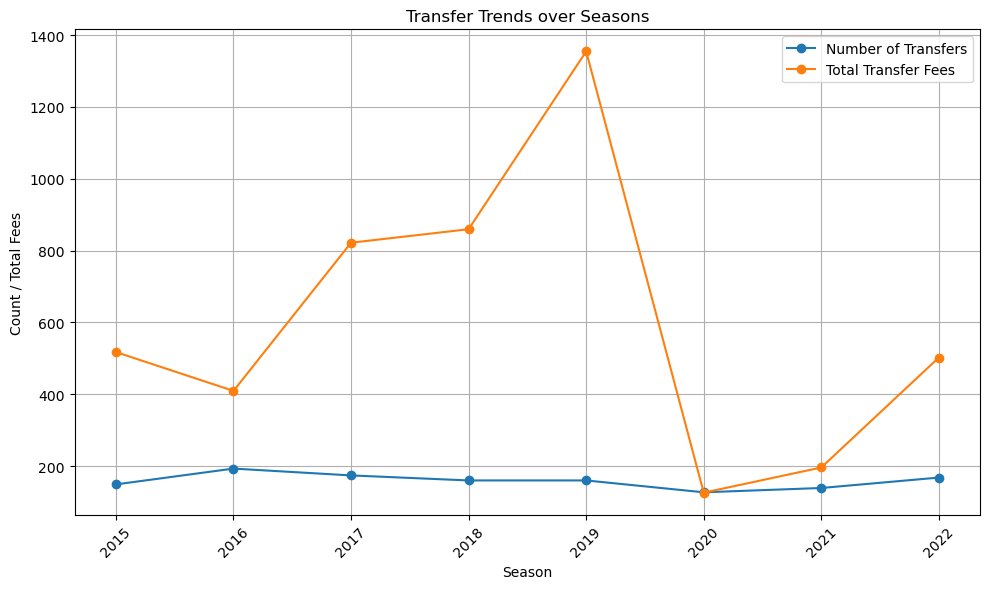

In [8]:
season_agg = merged_df.groupby(by='season_of_transfer').agg({
    'player_id': 'count',
    'transfer_fee': 'sum'
}).reset_index()


plt.figure(figsize=(10, 6))
plt.plot(season_agg['season_of_transfer'], season_agg['player_id'], marker='o', label='Number of Transfers')
plt.plot(season_agg['season_of_transfer'], season_agg['transfer_fee'], marker='o', label='Total Transfer Fees')

plt.xlabel('Season')
plt.ylabel('Count / Total Fees')
plt.title('Transfer Trends over Seasons')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

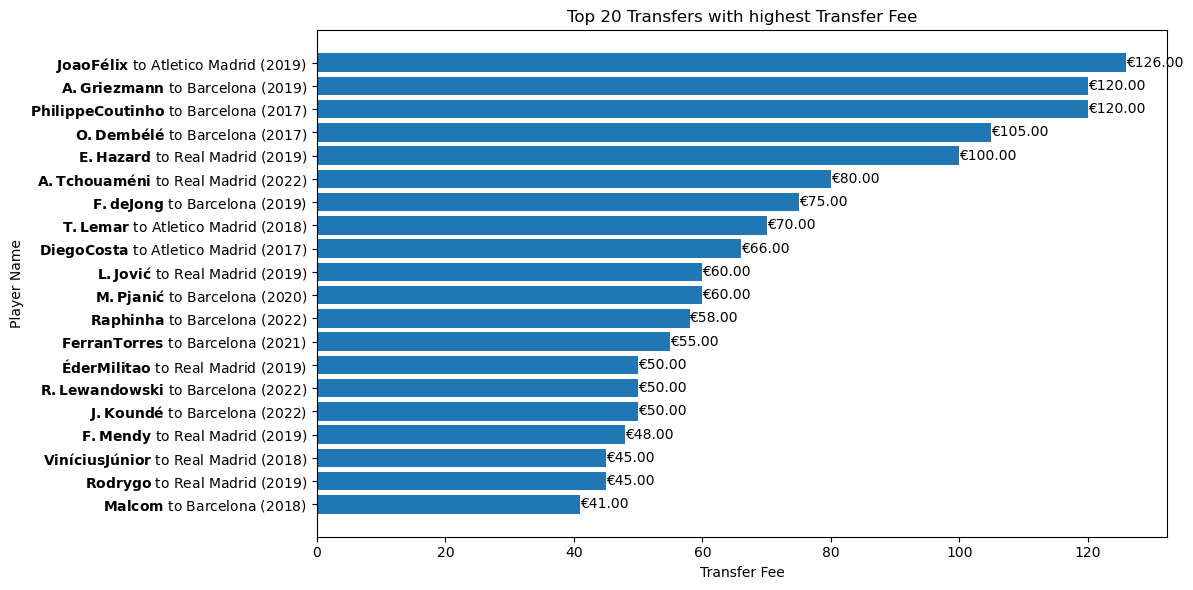

In [9]:
top_transfers = merged_df.sort_values(by='transfer_fee', ascending=False).head(20)

# Create labels for Y-axis
y_labels = [f"$\mathbf{{{name}}}$ to {team} ({int(season)})" for name, team, season in zip(top_transfers['player_name'], top_transfers['transfers_teams_in_name'], top_transfers['season_of_transfer'])]

# Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(y_labels, top_transfers['transfer_fee'])

# Add transfer fee as labels to the bars
for bar, fee in zip(bars, top_transfers['transfer_fee']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{fee:.2f}", va='center')
        
plt.xlabel('Transfer Fee')
plt.ylabel('Player Name')
plt.title('Top 20 Transfers with highest Transfer Fee')
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()

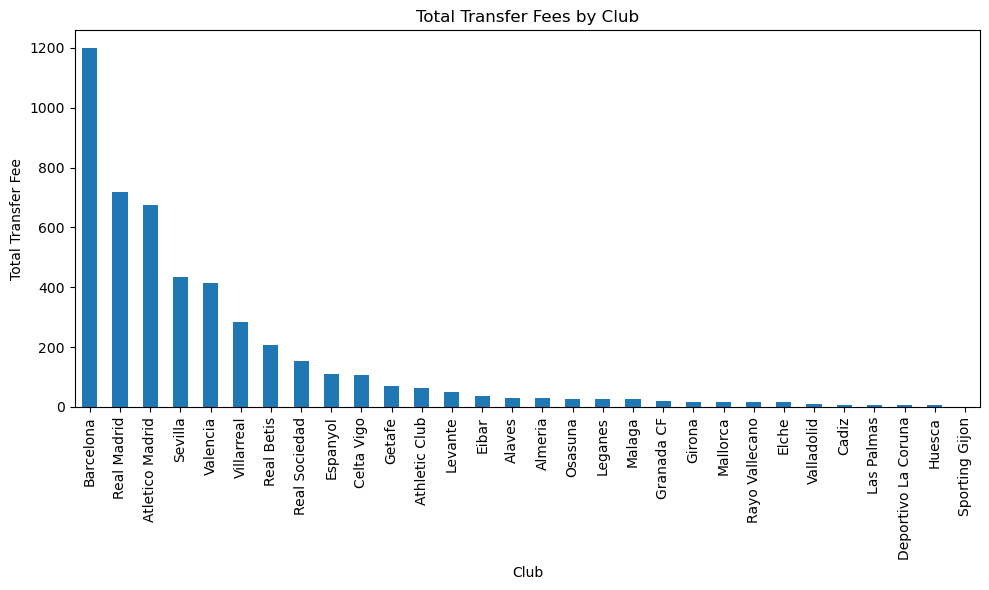

In [10]:
club_transfer_sums = merged_df.groupby(by='transfers_teams_in_name')['transfer_fee'].sum().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
club_transfer_sums.plot(kind='bar')
plt.xlabel('Club')
plt.ylabel('Total Transfer Fee')
plt.title('Total Transfer Fees by Club')
plt.xticks(rotation=90) 

plt.tight_layout()
plt.show()

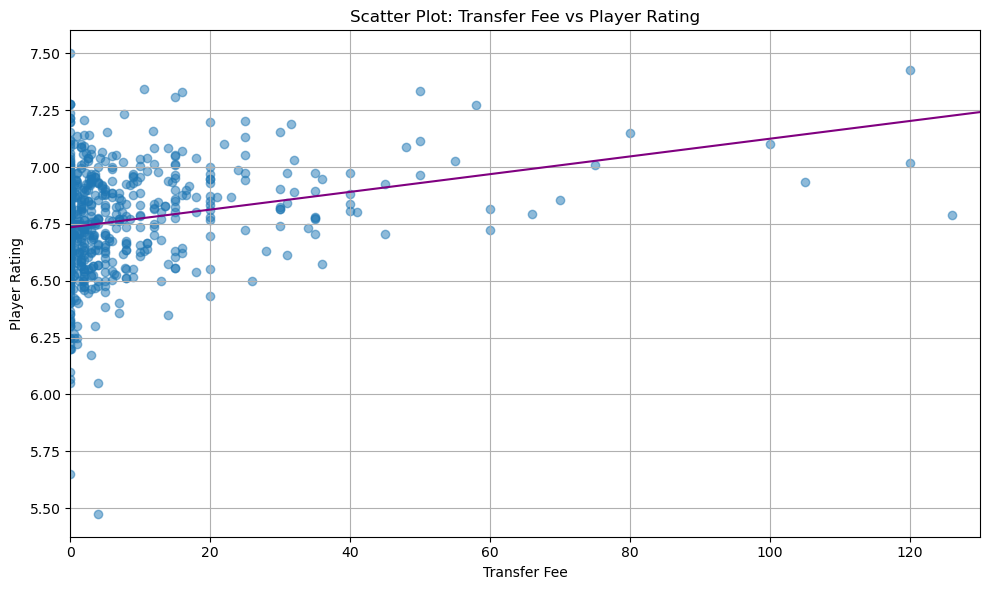

In [11]:
# Filter out rows with missing transfer fees or player ratings
filtered_df = merged_df.dropna(subset=['transfer_fee', 'statistics_games_rating'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['transfer_fee'], filtered_df['statistics_games_rating'], alpha=0.5)
plt.title('Scatter Plot: Transfer Fee vs Player Rating')
plt.xlabel('Transfer Fee')
plt.ylabel('Player Rating')

plt.xlim(0, 130)

# Calculate the trend line using linear regression
slope, intercept, r_value, p_value, std_err = linregress(filtered_df['transfer_fee'], filtered_df['statistics_games_rating'])

x = np.array([0, 130])
y = slope * x + intercept
plt.plot(x, y, color='purple', label='Trend Line')

plt.grid(True)
plt.tight_layout()

plt.show()

#### 3.3 Performance metric

##### Calculate 'performance_metric' parameter to evaluate players performance

In [12]:
# Create DafaFrame that includes data to calculate 'performance_metric'
selected_columns = ['statistics_games_rating', 'statistics_goals_total', 'statistics_goals_assists', 'statistics_passes_key', 'statistics_goals_saves', 'statistics_tackles_total', 'statistics_tackles_interceptions']
weights = [0.25, 0.15, 0.1, 0.1, 0.2, 0.1, 0.1] # assaign weights for parameters in {selected_columns}

performance_data_df = merged_df[selected_columns]
performance_data_df.fillna(0.0, inplace=True)

# Normalize data and calculate 'performance_metric'
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(performance_data_df)

performance_metric = (normalized_data * weights).sum(axis=1)
merged_df['performance_metric'] = performance_metric

C:\Users\Adrian\AppData\Local\Temp\ipykernel_2260\498379215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_data_df.fillna(0.0, inplace=True)


In [13]:
# TOP 10 Transfer based on 'performance_metric'
print("\033[1m" + "TOP 10 Transfer based on 'performance_metric" + "\033[0m")
merged_df.sort_values(by='performance_metric', ascending=False)[['player_name', 'transfers_teams_in_name', 'season_of_transfer', 'transfer_fee', 'performance_metric']].head(10)

TOP 10 Transfer based on 'performance_metric


,player_name,transfers_teams_in_name,season_of_transfer,transfer_fee,performance_metric
11,R. Lewandowski,Barcelona,2022,50.0,0.511568
135,Filipe Luís,Atletico Madrid,2015,16.0,0.489360
297,Santi Cazorla,Villarreal,2018,0.0,0.482827
776,Illarramendi,Real Sociedad,2015,15.0,0.468834
963,Pedro León,Eibar,2016,0.0,0.465089
506,Iago Aspas,Celta Vigo,2015,5.3,0.451559
4,Raphinha,Barcelona,2022,58.0,0.446912
59,L. Suárez,Atletico Madrid,2020,0.0,0.446374
1242,Pedro Mosquera,Deportivo La Coruna,2015,0.0,0.443698
125,Raúl García,Athletic Club,2015,NaN,0.443566


##### Distribution of 'performance_metric'

<function matplotlib.pyplot.show(close=None, block=None)>

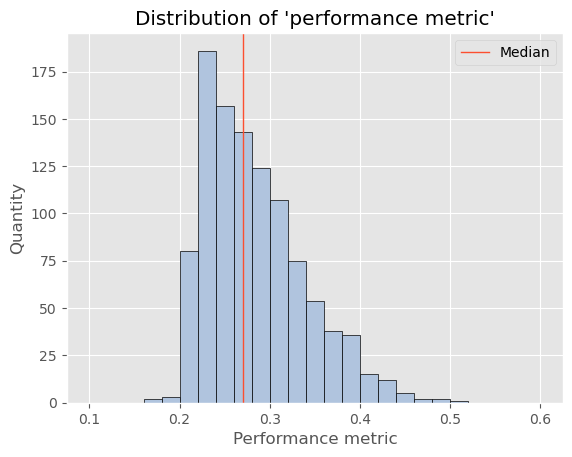

In [14]:
# Filter data for histogram
filtered_data = merged_df[merged_df['performance_metric'] > 0.05]['performance_metric'] 
median_performance = filtered_data.median()

#Calculate bins list
start, end, step = 0.1, 0.6, 0.025
bins = [round(x / 100, 2) for x in list(range(int(start * 100), int(end * 100) + 1, int(step * 100)))]

plt.style.use('ggplot')
plt.hist(filtered_data, bins=bins, edgecolor='black', color='lightsteelblue')
plt.axvline(median_performance, color='#fc4f30', linewidth=1, label='Median')
plt.legend()

plt.xlabel('Performance metric')
plt.ylabel('Quantity')
plt.title("Distribution of 'performance metric'")

plt.tight_layout
plt.show

##### Clubs with best performance_metric ratio (per 1 transfer)

In [19]:
# Group data by clubs and calculate 'transfer_performance_ratio' for each (mean value of performance_ratio / 1 transfer)
grouped_data = merged_df.groupby(by='transfers_teams_in_name')
transfer_counts = grouped_data['performance_metric'].count()
performance_sum = grouped_data['performance_metric'].sum()

performance_metric_ratio = performance_sum / transfer_counts

# Normalize data 
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(performance_metric_ratio.values.reshape(-1,1))

ratio_normalized = pd.Series(normalized_data.flatten(), index=performance_metric_ratio.index)

<function matplotlib.pyplot.show(close=None, block=None)>

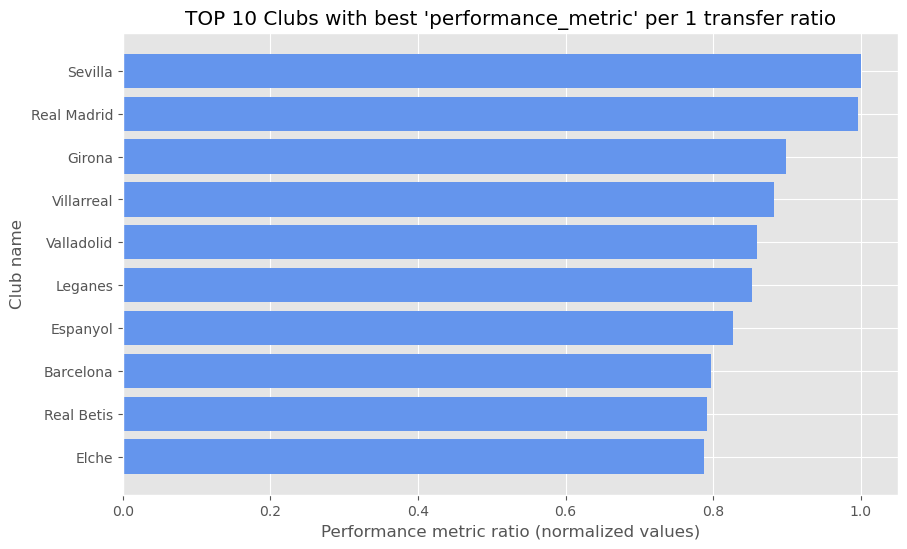

In [20]:
filtered_club_ratio = ratio_normalized.sort_values(ascending=False).head(10)

plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.barh(filtered_club_ratio.index, filtered_club_ratio, color='cornflowerblue')


plt.xlabel('Performance metric ratio (normalized values)')
plt.ylabel('Club name')
plt.title("TOP 10 Clubs with best 'performance_metric' per 1 transfer ratio")
plt.gca().invert_yaxis() 

plt.tight_layout
plt.show


#### 3.4 Transfers dynamics between clubs

In [21]:
# Create a DataFrame that contains info about transfers between pairs of clubs.
transfer_pairs = merged_df.groupby(by=['transfers_teams_in_name', 'transfers_teams_out_name']).agg({'player_id': 'count', 'transfer_fee': 'sum', 'performance_metric': 'sum', 'statistics_goals_total': 'sum'}).reset_index()
transfer_pairs.columns = ['transfers_teams_in_name', 'transfers_teams_out_name', 'transfers_count', 'total_transfers_fee', 'performance_metric_sum', 'goals_sum']

transfer_pairs['Pair'] = np.where(transfer_pairs['transfers_teams_in_name'] < transfer_pairs['transfers_teams_out_name'], 
                         transfer_pairs['transfers_teams_in_name'] + '-' + transfer_pairs['transfers_teams_out_name'],
                         transfer_pairs['transfers_teams_out_name'] + '-' + transfer_pairs['transfers_teams_in_name'])

# Group data by Pairs 
grouped_pairs = transfer_pairs.groupby('Pair').agg({'transfers_count': 'sum', 'total_transfers_fee': 'sum', 'performance_metric_sum': 'sum', 'goals_sum': 'sum'}).reset_index()

# Calculate additional columns
grouped_pairs['avg_transfer_fee'] = grouped_pairs['total_transfers_fee'] / grouped_pairs['transfers_count']
grouped_pairs['avg_performance_metric'] = grouped_pairs['performance_metric_sum'] / grouped_pairs['transfers_count']
grouped_pairs['avg_goals'] = grouped_pairs['goals_sum'] / grouped_pairs['transfers_count']

grouped_pairs.head(3)

,Pair,transfers_count,total_transfers_fee,performance_metric_sum,goals_sum,avg_transfer_fee,avg_performance_metric,avg_goals
0,AC Milan-Alaves,1,3.0,0.287311,1.0,3.0,0.287311,1.0
1,AC Milan-Atletico Madrid,2,15.0,0.589089,10.0,7.5,0.294545,5.0
2,AC Milan-Barcelona,1,0.0,0.266257,1.0,0.0,0.266257,1.0


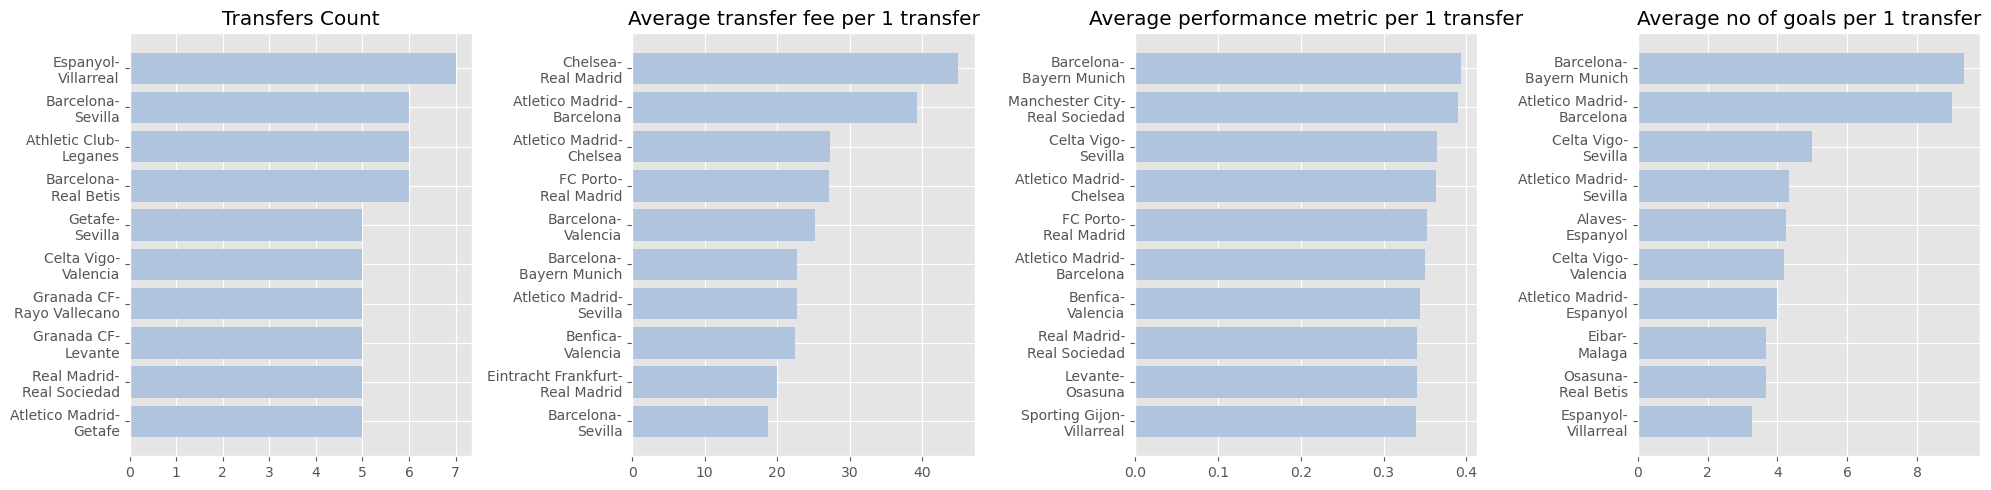

In [22]:
# Change display of 'Pair' to better readibility on chart
fixed_pairs = grouped_pairs.copy()
fixed_pairs['Pair'] = fixed_pairs['Pair'].str.replace('-', '-\n')

# Create ssequence of separate bar plots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.style.use('ggplot')

# Bar plot for 'transfers_count'
top_count = fixed_pairs.sort_values('transfers_count', ascending=False).head(10)
axs[0].barh(top_count['Pair'], top_count['transfers_count'], color='lightsteelblue')
axs[0].set_title('Transfers Count')
axs[0].invert_yaxis()

# Bar plot for 'transfer fee' per 1 transfer
top_avg_fee = fixed_pairs[fixed_pairs['transfers_count'] > 2].sort_values('avg_transfer_fee', ascending=False).head(10) # consider only pairs that made > 2 transfers
axs[1].barh(top_avg_fee['Pair'], top_avg_fee['avg_transfer_fee'], color='lightsteelblue')
axs[1].set_title('Average transfer fee per 1 transfer')
axs[1].invert_yaxis()

# Bar plot for 'performance_metric_sum' per 1 transfer
top_performance = fixed_pairs[fixed_pairs['transfers_count'] > 2].sort_values('avg_performance_metric', ascending=False).head(10) # consider only pairs that made > 2 transfers
axs[2].barh(top_performance['Pair'], top_performance['avg_performance_metric'], color='lightsteelblue')
axs[2].set_title('Average performance metric per 1 transfer')
axs[2].invert_yaxis()

# Bar plot for 'goals_sum' per 1 transfer
top_goals = fixed_pairs[fixed_pairs['transfers_count'] > 2].sort_values('avg_goals', ascending=False).head(10) # consider only pairs that made > 2 transfers
axs[3].barh(top_goals['Pair'], top_goals['avg_goals'], color='lightsteelblue')
axs[3].set_title('Average no of goals per 1 transfer')
axs[3].invert_yaxis()

plt.tight_layout()

plt.show()

##### Correlation between Total Transfer Fee, Performance Metric Sum and Goals Sum

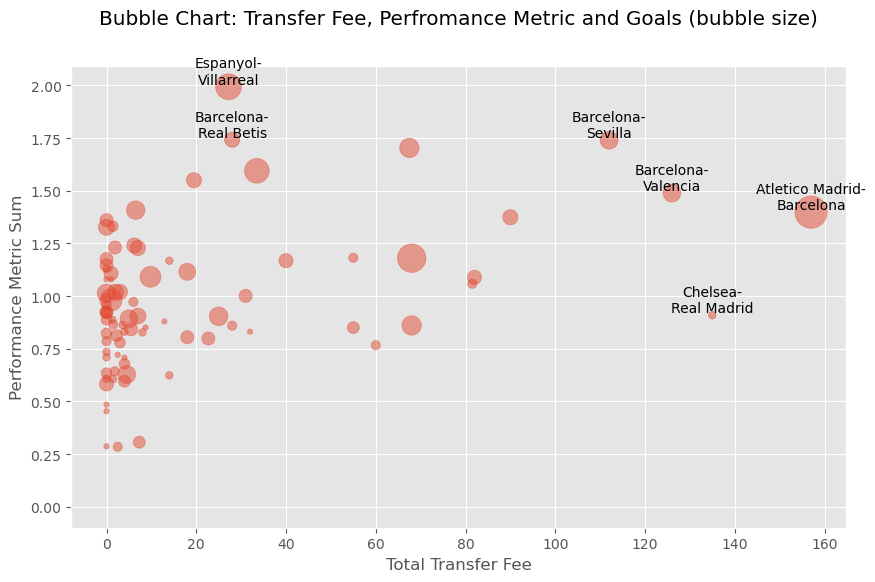

In [53]:
# Get Pairs with at least 3 transfers
most_transfers_pairs = grouped_pairs[grouped_pairs['transfers_count'] > 2].sort_values('total_transfers_fee')

x = most_transfers_pairs['total_transfers_fee']
y = most_transfers_pairs['performance_metric_sum']
bubble_size = most_transfers_pairs['goals_sum'] * 15

plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.scatter(x, y, s=bubble_size, alpha=0.5)

# Get labels for top 3 pairs for X and Y axis data
top_transfer_fee_pairs = most_transfers_pairs.sort_values('total_transfers_fee', ascending=False).head(3)
top_performance_pairs = most_transfers_pairs.sort_values('performance_metric_sum', ascending=False).head(3)

for i, row in top_transfer_fee_pairs.iterrows():
    label_text = row['Pair'].replace('-', '-\n')
    plt.annotate(label_text, (row['total_transfers_fee'], row['performance_metric_sum']), fontsize=10, ha='center', va='bottom')
    
for i, row in top_performance_pairs.iterrows():
    label_text = row['Pair'].replace('-', '-\n')
    plt.annotate(label_text, (row['total_transfers_fee'], row['performance_metric_sum']), fontsize=10, ha='center', va='bottom')

plt.xlabel('Total Transfer Fee')
plt.ylabel('Performance Metric Sum')
plt.title('Bubble Chart: Transfer Fee, Perfromance Metric and Goals (bubble size)', pad=30)

plt.show()


#### 3.5 Questions

##### 1. Which club has payed most for 1 striker's goal  ?

In [54]:
filtered_df = merged_df.copy()
filtered_df = filtered_df[filtered_df['statistics_games_position'] == 'Attacker']
filtered_df['price_for_goal'] = filtered_df['transfer_fee'] / filtered_df['statistics_goals_total']
filtered_df['price_for_goal'].replace(np.inf, np.nan, inplace=True)
filtered_df = filtered_df.dropna(subset=['price_for_goal'])

print("\033[1m" + "TOP 10 most expensive strikers based on price per 1 goal" + "\033[0m")
filtered_df[['player_name', 'price_for_goal', 'transfers_teams_in_name', 'transfers_teams_out_name', 'season_of_transfer', 'transfer_fee', 'statistics_goals_total']].sort_values('price_for_goal', ascending=False).head(10)

TOP 10 most expensive strikers based on price per 1 goal


,player_name,price_for_goal,transfers_teams_in_name,transfers_teams_out_name,season_of_transfer,transfer_fee,statistics_goals_total
748,E. Hazard,100.0,Real Madrid,Chelsea,2019,100.0,1.0
69,Malcom,41.0,Barcelona,Bordeaux,2018,41.0,1.0
9,O. Dembélé,35.0,Barcelona,Borussia Dortmund,2017,105.0,3.0
766,L. Jović,30.0,Real Madrid,Eintracht Frankfurt,2019,60.0,2.0
754,Rodrygo,22.5,Real Madrid,Santos,2019,45.0,2.0
753,Vinícius Júnior,22.5,Real Madrid,Flamengo,2018,45.0,2.0
115,Diego Costa,22.0,Atletico Madrid,Chelsea,2017,66.0,3.0
147,Joao Félix,21.0,Atletico Madrid,Benfica,2019,126.0,6.0
120,L. Vietto,20.0,Atletico Madrid,Villarreal,2015,20.0,1.0
1033,U. Sadiq,20.0,Real Sociedad,Almeria,2022,20.0,1.0


##### 2. What is the distribution of performance metric by age?

C:\Users\Adrian\AppData\Local\Temp\ipykernel_2260\60394219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_group'] = ['Under 22' if age < 22 else


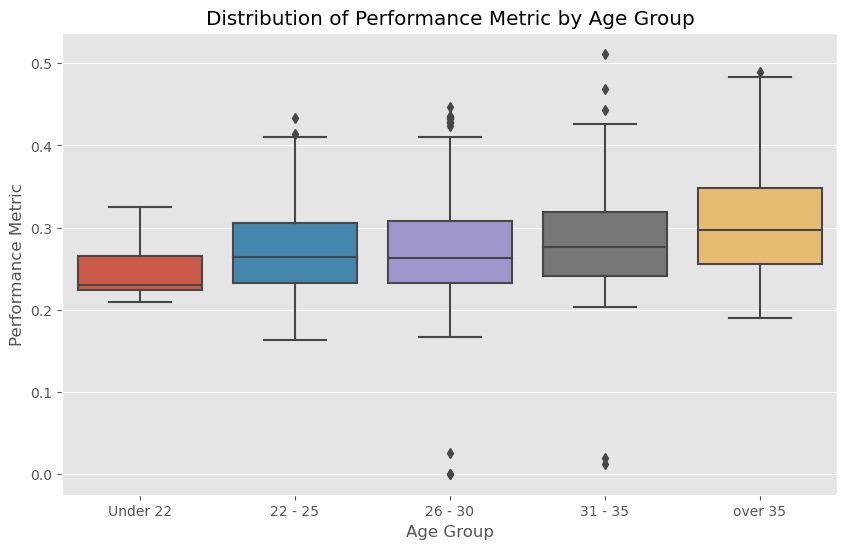

In [55]:
# Define age groups
filtered_df = merged_df[['player_name', 'player_age', 'statistics_games_rating', 'performance_metric']]
filtered_df['age_group'] = ['Under 22' if age < 22 else 
                            '22 - 25' if age in range(22, 26) else
                            '26 - 30' if age in range(26, 31) else
                            '31 - 35' if age in range(31, 36) else
                            'over 35' for age in filtered_df['player_age']]
filtered_df = filtered_df[filtered_df['performance_metric'] != 0.0] 

plt.style.use('ggplot')
plt.figure(figsize=(10,6))

sns.boxplot(data=filtered_df, x='age_group', y='performance_metric', order=['Under 22', '22 - 25', '26 - 30', '31 - 35', 'over 35' ])

plt.xlabel('Age Group')
plt.ylabel('Performance Metric')
plt.title('Distribution of Performance Metric by Age Group')
plt.show()


##### 3. Comparision of transfers from Spanish clubs and foreign transfers

In [57]:
# Create column for categorize transfers
merged_df['transfer_type'] = [None if np.isnan(id)  else
                              'Spanish' if id in df_spanish_teams['team_id'].unique() else
                              'Foreign' for id in merged_df['transfers_teams_out_id'].astype(float)]

# Drop Nones for futher analyse
category_df = merged_df.dropna(subset=['transfer_type'])

# Create grouped DF
category_df_grouped = category_df.groupby('transfer_type').agg({'statistics_games_rating': 'mean', 'transfer_fee': 'mean', 'statistics_goals_total': 'mean'})
category_df_grouped.columns = ['player_rating_avg', 'transfer_fee_avg', 'goals_total_avg']
category_df_grouped

,player_rating_avg,transfer_fee_avg,goals_total_avg
transfer_type,,,
Foreign,6.788060,9.059142,1.684982
Spanish,6.686304,4.201582,1.106796


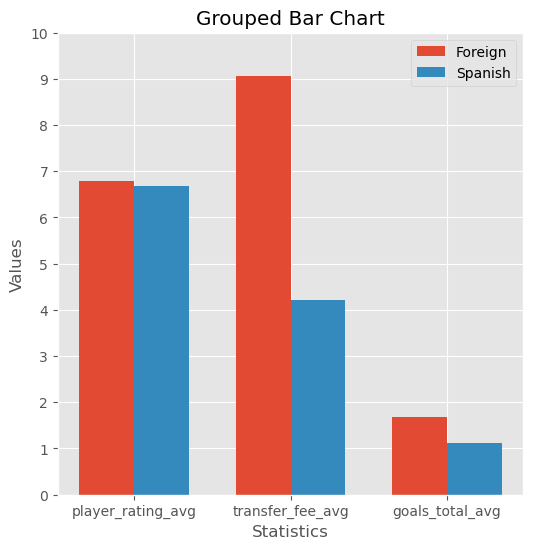

In [58]:
# Provide categories and data
x = np.arange(len(category_df_grouped.columns))
foreign_data = category_df_grouped.loc['Foreign'].values
spanish_data = category_df_grouped.loc['Spanish'].values

fig, ax = plt.subplots(figsize=(6, 6))
plt.style.use('ggplot')
width = 0.35

# Plot foreign data
ax.bar(x - width/2, foreign_data, width, label='Foreign')

# Plot spanish data
ax.bar(x + width/2, spanish_data, width, label='Spanish')

ax.set_xlabel('Statistics')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart')
ax.set_xticks(x)
ax.set_xticklabels(category_df_grouped.columns)
ax.set_yticks(np.arange(0, 11, 1))
ax.legend()

plt.show()

##### 4. Correlation between offensive statistics

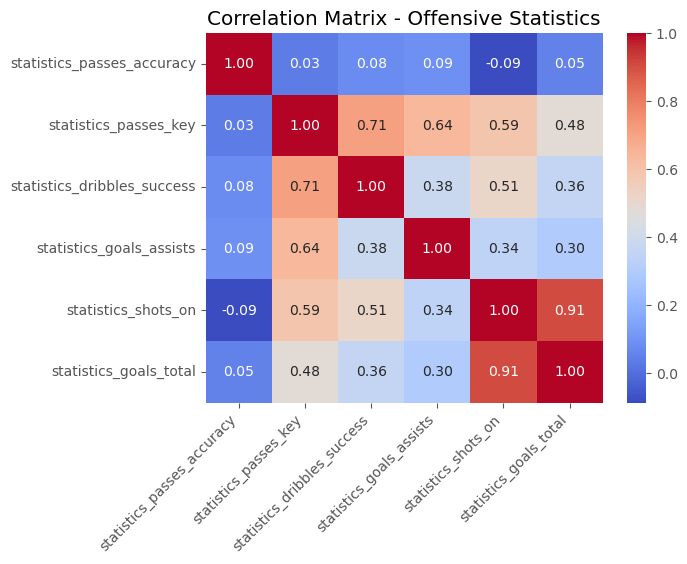

In [59]:
# Select statistics to correlation
selected_variables = [
    'statistics_passes_accuracy',
    'statistics_passes_key',
    'statistics_dribbles_success',
    'statistics_goals_assists',
    'statistics_shots_on',
    'statistics_goals_total'  
]

correlation_matrix = merged_df[selected_variables].corr()

# Create a heatmap for visualization
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Offensive Statistics")
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()